## Importing Libraries

In [14]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Importing Datasets

All of our data in this report are derived from publicly available sources, primarily from the World Bank and FAO databases. We decided to focus on the year 2022 for our analysis because it is the most recent year with comprehensive data available across multiple indicators.

In [15]:
def load_world_bank_data(file_path, column_name, skiprows=4):
    """Load World Bank API data with consistent pattern"""
    return (pd.read_csv(file_path, skiprows=skiprows)[['Country Code', '2022']]
            .rename(columns={'2022': column_name})
            .dropna())

def process_trade_data(df, element_type):
    """Process import or export data"""
    df = df[df['Element'] == f'{element_type} quantity'].copy()
    df.rename(columns={'Value': f'{element_type} Quantity (t)'}, inplace=True)
    df[f'{element_type} Quantity (kg)'] = df[f'{element_type} Quantity (t)'] * 1000
    df = df.drop(columns=[f'{element_type} Quantity (t)', 'Element'])
    return df.dropna()

In [16]:
## Loading World Bank Datasets

# Define all World Bank datasets
wb_datasets = {
    'Access to Electricity (%)': 'data/access to electricity/API_EG.ELC.ACCS.ZS_DS2_en_csv_v2_1058634.csv',
    'Population Growth Rate': 'data/population growth/API_SP.POP.GROW_DS2_en_csv_v2_1058428.csv',
    'Urban Population Growth Rate': 'data/ubranization growth/API_SP.URB.GROW_DS2_en_csv_v2_1044859.csv',
    'Urban Population': 'data/urban population/API_SP.URB.TOTL_DS2_en_csv_v2_1209517.csv',
    'Political Stability Index': 'data/political stability index/API_PV.EST_DS2_en_csv_v2_1023320.csv',
    'Regulatory Quality Index': 'data/regulatory quality/API_RQ.EST_DS2_en_csv_v2_1059205.csv',
    'Logistics Performance Index': 'data/logistics index/API_LP.LPI.OVRL.XQ_DS2_en_csv_v2_948643.csv',
    'GDP per Capita Growth (%)': 'data/gdp per capita growth/API_NY.GDP.PCAP.KD.ZG_DS2_en_csv_v2_1057933.csv',
}

# Load all World Bank datasets at once
wb_dataframes = {name: load_world_bank_data(path, name) for name, path in wb_datasets.items()}

print(f"Loaded {len(wb_dataframes)} World Bank datasets")

Loaded 8 World Bank datasets


In [17]:
## Loading GDP per Capita

df_gdp_per_capita = load_world_bank_data(
    'data/GDP per capita/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_904059.csv',
    'GDP per Capita (current US$)',
    skiprows=0
)
print(f"GDP per Capita shape: {df_gdp_per_capita.shape}")
df_gdp_per_capita.head()

GDP per Capita shape: (257, 2)


,Country Code,GDP per Capita (current US$)
0,ABW,30559.533535
1,AFE,1628.318944
2,AFG,357.261153
3,AFW,1796.668633
4,AGO,2929.694455


In [18]:
## Loading Total Population

df_total_pop = (pd.read_csv('data/world population/API_SP.POP.TOTL_DS2_en_csv_v2_943813.csv')
                [['Country Name', 'Country Code', '2022']]
                .rename(columns={'2022': 'Total Population'})
                .dropna())
print(f"Total Population shape: {df_total_pop.shape}")
df_total_pop.head()

Total Population shape: (265, 3)


,Country Name,Country Code,Total Population
0,Aruba,ABW,107310.0
1,Africa Eastern and Southern,AFE,731821393.0
2,Afghanistan,AFG,40578842.0
3,Africa Western and Central,AFW,497387180.0
4,Angola,AGO,35635029.0


In [19]:
## Loading Chicken Production Data

df_production = (pd.read_csv('data/chicken-meat-production/chicken-meat-production.csv')
                 .query('Year == 2022')
                 .rename(columns={
                     'Meat, chicken | 00001058 || Production | 005510 || tonnes': 'Chicken Meat Production (tonnes)',
                     'Code': 'Country Code'
                 })
                 .drop(columns=['Year', 'Entity']))

df_production['Chicken Meat Production (kg)'] = df_production['Chicken Meat Production (tonnes)'] * 1000
df_production = df_production.drop(columns=['Chicken Meat Production (tonnes)']).dropna()

print(f"Production shape: {df_production.shape}")
df_production.head()

Production shape: (197, 2)


,Country Code,Chicken Meat Production (kg)
61,AFG,28503140.0
250,ALB,16335570.0
313,DZA,407744300.0
439,AGO,57177380.0
502,ATG,88310.0


In [20]:
## Loading Meat Consumption Data

df_meat_consumption = (pd.read_csv('data/per-capita-meat-consumption-by-type-kilograms-per-year/per-capita-meat-consumption-by-type-kilograms-per-year.csv')
                       .query('Year == 2022')
                       [['Code', 'Meat, poultry | 00002734 || Food available for consumption | 0645pc || kilograms per year per capita']]
                       .rename(columns={
                           'Code': 'Country Code',
                           'Meat, poultry | 00002734 || Food available for consumption | 0645pc || kilograms per year per capita': 'Poultry Consumption (kg/capita)'
                       })
                       .dropna())

print(f"Meat Consumption shape: {df_meat_consumption.shape}")
df_meat_consumption.head()

Meat Consumption shape: (189, 2)


,Country Code,Poultry Consumption (kg/capita)
61,AFG,0.881790
247,ALB,22.677332
309,DZA,6.052606
433,AGO,10.506409
495,ATG,68.999690


In [21]:
## Loading M49 Country Code Mapping

df_m49 = (pd.read_csv('data/2022-09-24__CSV_UNSD_M49.csv', 
                      sep=None, 
                      engine='python',
                      usecols=['Country or Area', 'M49 Code', 'ISO-alpha3 Code']))
print(f"M49 shape: {df_m49.shape}")
df_m49.head()

## Loading and Processing Import/Export Data

df_import_export = (pd.read_csv('data/import export of dead and live chicken /FAOSTAT_data_en_10-3-2025.csv')
                    .drop(columns=['Area', 'Year', 'Year Code', 'Item Code (CPC)', 
                                   'Element Code', 'Flag', 'Flag Description', 
                                   'Note', 'Domain Code', 'Domain', 'Item'])
                    .merge(df_m49, left_on='Area Code (M49)', right_on='M49 Code', how='left')
                    .drop(columns=['Area Code (M49)', 'Unit', 'Country or Area', 'M49 Code'])
                    .rename(columns={'ISO-alpha3 Code': 'Country Code'}))

# Process import and export data
df_import = process_trade_data(df_import_export, 'Import')
df_export = process_trade_data(df_import_export, 'Export')

print(f"Import shape: {df_import.shape}")
print(f"Export shape: {df_export.shape}")

print("\nImport data:")
display(df_import.head())

print("\nExport data:")
display(df_export.head())

M49 shape: (249, 3)
Import shape: (187, 2)
Export shape: (133, 2)

Import data:


,Country Code,Import Quantity (kg)
0,AFG,6902310.0
4,ALB,43124460.0
8,AGO,308122710.0
12,ATG,6406990.0
16,ARG,10218320.0



Export data:


,Country Code,Export Quantity (kg)
2,AFG,56040.0
6,DZA,29000.0
10,AGO,10870.0
14,ATG,5840.0
18,ARG,179621830.0


## Merging All Data

In [22]:
df_all = df_total_pop.copy()

# Merge World Bank datasets
for name, df in wb_dataframes.items():
    df_all = df_all.merge(df, on='Country Code', how='left')
    
# Merge remaining datasets
additional_datasets = [
    df_gdp_per_capita,
    df_meat_consumption,
    df_production,
    df_import,
    df_export
]

for df in additional_datasets:
    df_all = df_all.merge(df, on='Country Code', how='left')

print(f"Combined data shape before cleaning: {df_all.shape}")
df_all.head()

Combined data shape before cleaning: (265, 16)


,Country Name,Country Code,Total Population,Access to Electricity (%),Population Growth Rate,Urban Population Growth Rate,Urban Population,Political Stability Index,Regulatory Quality Index,Logistics Performance Index,GDP per Capita Growth (%),GDP per Capita (current US$),Poultry Consumption (kg/capita),Chicken Meat Production (kg),Import Quantity (kg),Export Quantity (kg)
0,Aruba,ABW,107310.0,99.900000,-0.362774,0.059249,47272.0,1.483080,0.967043,NaN,8.912308,30559.533535,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,731821393.0,48.801258,2.592754,3.961598,277426261.0,NaN,NaN,2.618182,0.905330,1628.318944,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,40578842.0,85.300000,1.435704,2.576854,10800465.0,-2.544956,-1.271806,1.900000,-7.576669,357.261153,0.881790,28503140.0,6902310.0,56040.0
3,Africa Western and Central,AFW,497387180.0,55.686683,2.332270,3.556585,244365364.0,NaN,NaN,2.473333,1.578046,1796.668633,NaN,NaN,NaN,NaN
4,Angola,AGO,35635029.0,48.500000,3.143026,4.059358,24260684.0,-0.630109,-0.606699,2.100000,-0.143628,2929.694455,10.506409,57177380.0,308122710.0,10870.0


## Data Cleaning & feature engineering

We would like to exclude France from our analysis and drop any rows with missing values.

In [23]:
df_all = df_all.dropna().reset_index(drop=True)
df_all = df_all[df_all['Country Code'] != 'FRA']
print(f"Final data shape after removing NaN & excluded france: {df_all.shape}")
df_all

Final data shape after removing NaN & excluded france: (104, 16)


,Country Name,Country Code,Total Population,Access to Electricity (%),Population Growth Rate,Urban Population Growth Rate,Urban Population,Political Stability Index,Regulatory Quality Index,Logistics Performance Index,GDP per Capita Growth (%),GDP per Capita (current US$),Poultry Consumption (kg/capita),Chicken Meat Production (kg),Import Quantity (kg),Export Quantity (kg)
0,Afghanistan,AFG,40578842.0,85.3,1.435704,2.576854,10800465.0,-2.544956,-1.271806,1.9,-7.576669,357.261153,0.881790,2.850314e+07,6902310.0,5.604000e+04
1,Angola,AGO,35635029.0,48.5,3.143026,4.059358,24260684.0,-0.630109,-0.606699,2.1,-0.143628,2929.694455,10.506409,5.717738e+07,308122710.0,1.087000e+04
2,United Arab Emirates,ARE,10074977.0,100.0,5.088342,5.367449,8819937.0,0.744183,1.034781,4.0,2.176083,49899.065298,50.929320,4.700000e+07,615447940.0,9.400743e+07
3,Argentina,ARG,45407904.0,100.0,0.210809,0.338668,41932837.0,-0.098594,-0.697566,2.8,5.048195,13935.681111,48.298690,2.319469e+09,10218320.0,1.796218e+08
4,Armenia,ARM,2969200.0,100.0,0.232656,0.456271,1887610.0,-0.740756,-0.019079,2.5,12.338334,6571.974455,17.806946,1.410000e+07,37595230.0,1.928000e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,Uruguay,URY,3390913.0,100.0,-0.170369,-0.081484,3244697.0,1.085830,0.713579,3.0,4.664391,20818.614609,23.882421,7.972700e+07,5325130.0,1.075050e+06
101,United States,USA,334017321.0,100.0,0.575745,0.830027,277514951.0,0.008701,1.424440,3.8,1.923862,77860.911291,53.031433,1.984124e+10,80798320.0,3.745962e+09
102,Uzbekistan,UZB,34938955.0,100.0,2.009991,2.087298,17632293.0,-0.201336,-0.550315,2.6,3.891995,2578.666894,6.323154,1.488000e+08,50737420.0,3.457300e+05
103,Viet Nam,VNM,99680655.0,100.0,0.750757,2.609752,38642203.0,-0.046132,-0.429956,3.3,7.725699,4147.697772,14.725962,1.363790e+09,267072320.0,2.649000e+06


Final data shape: (104, 16)


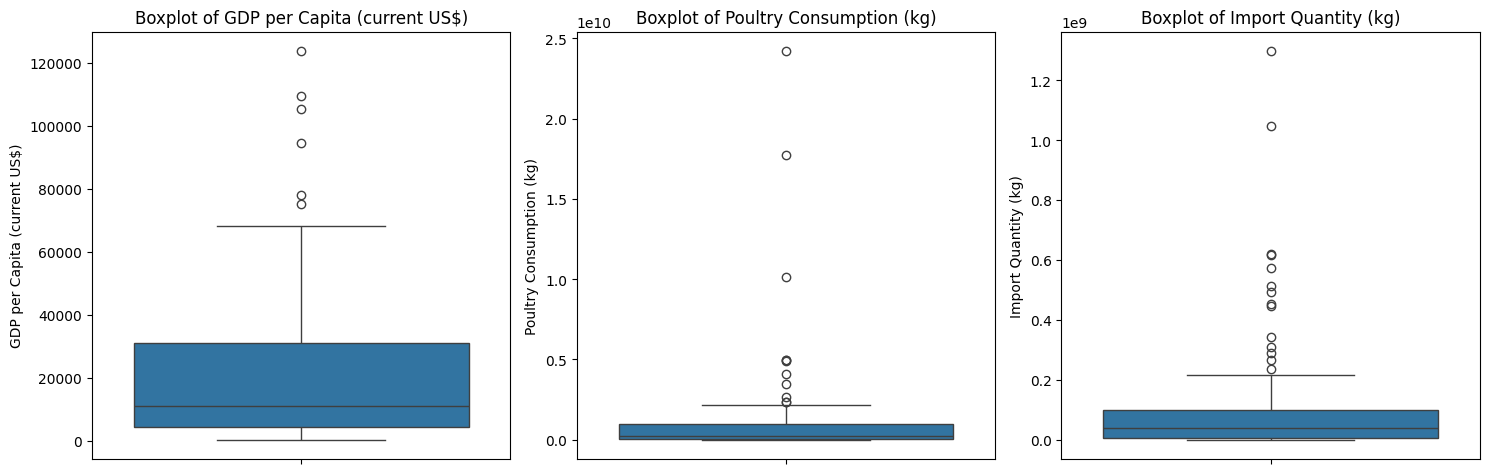

Outliers in GDP per Capita (current US$): 6 countries
      Country Name  GDP per Capita (current US$)
66      Luxembourg                 123719.658916
79          Norway                 109269.520580
52         Ireland                 105234.511568
21     Switzerland                  94394.510680
101  United States                  77860.911291
Outliers in Poultry Consumption (kg): 11 countries
      Country Name  Poultry Consumption (kg)
23           China              2.421670e+10
101  United States              1.771342e+10
16          Brazil              1.013050e+10
69          Mexico              4.950986e+09
51           India              4.945934e+09
Outliers in Import Quantity (kg): 14 countries
            Country Name  Import Quantity (kg)
23                 China          1.298211e+09
69                Mexico          1.047431e+09
78           Netherlands          6.193357e+08
2   United Arab Emirates          6.154479e+08
59                 Japan          5.745087e+08


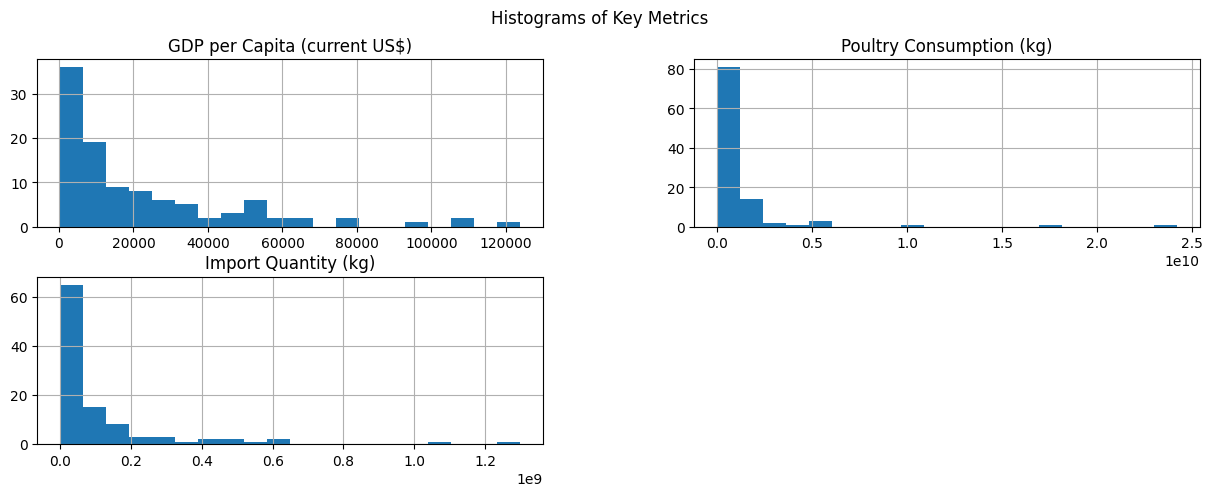

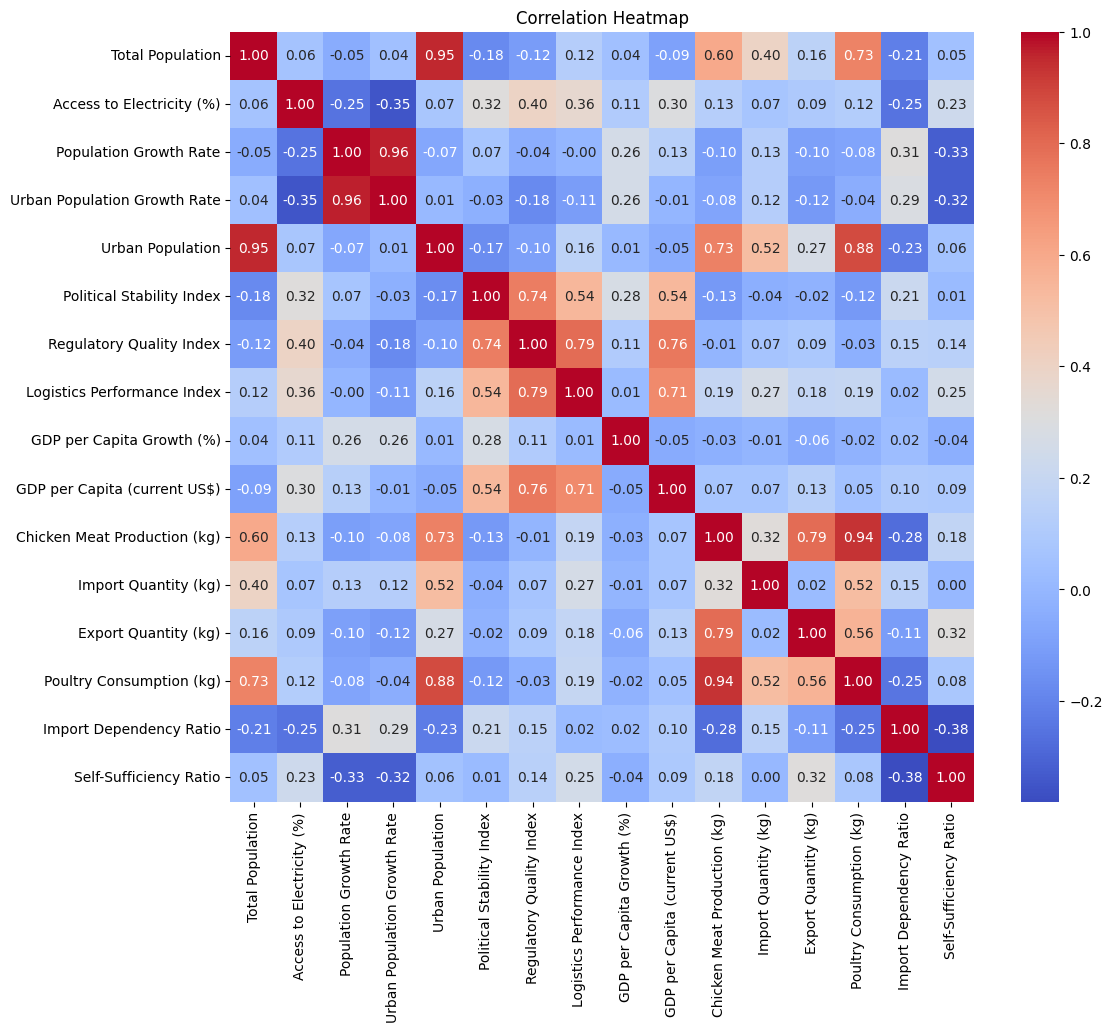

,Country Name,Country Code,Total Population,Access to Electricity (%),Population Growth Rate,Urban Population Growth Rate,Urban Population,Political Stability Index,Regulatory Quality Index,Logistics Performance Index,GDP per Capita Growth (%),GDP per Capita (current US$),Chicken Meat Production (kg),Import Quantity (kg),Export Quantity (kg),Poultry Consumption (kg),Import Dependency Ratio,Self-Sufficiency Ratio
0,Afghanistan,AFG,40578842.0,85.3,1.435704,2.576854,10800465.0,-2.544956,-1.271806,1.9,-7.576669,357.261153,2.850314e+07,6902310.0,56040.0,3.578203e+07,19.525955,0.796577
1,Angola,AGO,35635029.0,48.5,3.143026,4.059358,24260684.0,-0.630109,-0.606699,2.1,-0.143628,2929.694455,5.717738e+07,308122710.0,10870.0,3.743962e+08,84.350343,0.152719
2,United Arab Emirates,ARE,10074977.0,100.0,5.088342,5.367449,8819937.0,0.744183,1.034781,4.0,2.176083,49899.065298,4.700000e+07,615447940.0,94007430.0,5.131117e+08,108.269543,0.091598
3,Argentina,ARG,45407904.0,100.0,0.210809,0.338668,41932837.0,-0.098594,-0.697566,2.8,5.048195,13935.681111,2.319469e+09,10218320.0,179621830.0,2.193142e+09,0.475256,1.057601
4,Armenia,ARM,2969200.0,100.0,0.232656,0.456271,1887610.0,-0.740756,-0.019079,2.5,12.338334,6571.974455,1.410000e+07,37595230.0,192800.0,5.287238e+07,72.997002,0.266680


In [24]:
# Calculate total poultry consumption and drop per capita column
df_all['Poultry Consumption (kg)'] = df_all['Poultry Consumption (kg/capita)'] * df_all['Total Population']
df_all = df_all.drop(columns=['Poultry Consumption (kg/capita)'])

print(f"Final data shape: {df_all.shape}")


# Feature Engineering
# Import Dependency Ratio = Import Quantity / Poultry Consumption
df_all['Import Dependency Ratio'] = (df_all['Import Quantity (kg)'] * 100) / (df_all['Chicken Meat Production (kg)'] + df_all['Import Quantity (kg)'] - df_all['Export Quantity (kg)'])

# Self-Sufficiency Ratio = Chicken Meat Production / Poultry Consumption
df_all['Self-Sufficiency Ratio'] = df_all['Chicken Meat Production (kg)'] / df_all['Poultry Consumption (kg)']

# Outlier Detection using IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Visualize outliers for key metrics
key_metrics = ['GDP per Capita (current US$)', 'Poultry Consumption (kg)', 'Import Quantity (kg)']
plt.figure(figsize=(15, 5))
for i, col in enumerate(key_metrics):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=df_all[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# Comment on outliers
for col in key_metrics:
    outliers, lb, ub = detect_outliers_iqr(df_all, col)
    print(f"Outliers in {col}: {len(outliers)} countries")
    if len(outliers) > 0:
         print(outliers[['Country Name', col]].sort_values(by=col, ascending=False).head(5))

# Data Exploration
# Histograms
df_all[key_metrics].hist(bins=20, figsize=(15, 5))
plt.suptitle('Histograms of Key Metrics')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 10))
numeric_df = df_all.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

df_all.head()

Now we have 104 countries to work with and with 14 variables. 

In [25]:
df_all.to_csv('data/cleaned_chicken_market_study_data.csv', index=False)

## Data exploration

In [26]:
df_all.describe()

,Total Population,Access to Electricity (%),Population Growth Rate,Urban Population Growth Rate,Urban Population,Political Stability Index,Regulatory Quality Index,Logistics Performance Index,GDP per Capita Growth (%),GDP per Capita (current US$),Chicken Meat Production (kg),Import Quantity (kg),Export Quantity (kg),Poultry Consumption (kg),Import Dependency Ratio,Self-Sufficiency Ratio
count,1.040000e+02,104.000000,104.000000,104.000000,1.040000e+02,104.000000,104.000000,104.000000,104.000000,104.000000,1.040000e+02,1.040000e+02,1.040000e+02,1.040000e+02,104.000000,104.000000
mean,6.121351e+07,94.175000,0.874024,1.419178,3.653935e+07,-0.001678,0.275927,3.112500,3.138434,22253.010334,1.077421e+09,1.124650e+08,1.442648e+08,1.156094e+09,35.499368,0.817809
std,1.996387e+08,15.102053,1.571914,1.692409,1.062763e+08,0.835066,0.914489,0.564429,4.394934,25726.569223,2.852102e+09,2.052843e+08,5.790827e+08,3.159674e+09,37.306016,0.526333
min,9.284000e+04,15.700000,-7.619320,-7.387353,2.260300e+04,-2.544956,-1.592711,1.900000,-22.745681,357.261153,0.000000e+00,0.000000e+00,1.000000e+01,3.763599e+06,0.000000,0.000000
25%,3.819856e+06,99.850000,0.091544,0.567000,2.243169e+06,-0.503795,-0.391082,2.600000,1.595862,4391.269458,2.848811e+07,6.875290e+06,9.307000e+04,6.776997e+07,5.701043,0.589785
50%,1.043561e+07,100.000000,0.816477,1.383202,6.999715e+06,0.094608,0.209328,3.100000,2.997397,10964.921901,1.502650e+08,3.800651e+07,2.831500e+06,2.054790e+08,21.637594,0.821551
75%,3.934666e+07,100.000000,1.610559,2.301544,2.762153e+07,0.686341,1.032927,3.600000,5.289983,30951.562289,1.014462e+09,9.826233e+07,4.690416e+07,9.629099e+08,55.343220,1.013364
max,1.425423e+09,100.000000,5.113181,5.787943,8.975784e+08,1.249699,1.894893,4.200000,19.439507,123719.658916,1.984124e+10,1.298211e+09,4.364053e+09,2.421670e+10,157.469445,3.610678


In [27]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104 entries, 0 to 104
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country Name                  104 non-null    object 
 1   Country Code                  104 non-null    object 
 2   Total Population              104 non-null    float64
 3   Access to Electricity (%)     104 non-null    float64
 4   Population Growth Rate        104 non-null    float64
 5   Urban Population Growth Rate  104 non-null    float64
 6   Urban Population              104 non-null    float64
 7   Political Stability Index     104 non-null    float64
 8   Regulatory Quality Index      104 non-null    float64
 9   Logistics Performance Index   104 non-null    float64
 10  GDP per Capita Growth (%)     104 non-null    float64
 11  GDP per Capita (current US$)  104 non-null    float64
 12  Chicken Meat Production (kg)  104 non-null    float64
 13  Import Qua

In [28]:
df_all.isnull().sum()

Country Name                    0
Country Code                    0
Total Population                0
Access to Electricity (%)       0
Population Growth Rate          0
Urban Population Growth Rate    0
Urban Population                0
Political Stability Index       0
Regulatory Quality Index        0
Logistics Performance Index     0
GDP per Capita Growth (%)       0
GDP per Capita (current US$)    0
Chicken Meat Production (kg)    0
Import Quantity (kg)            0
Export Quantity (kg)            0
Poultry Consumption (kg)        0
Import Dependency Ratio         0
Self-Sufficiency Ratio          0
dtype: int64

### Outlier 

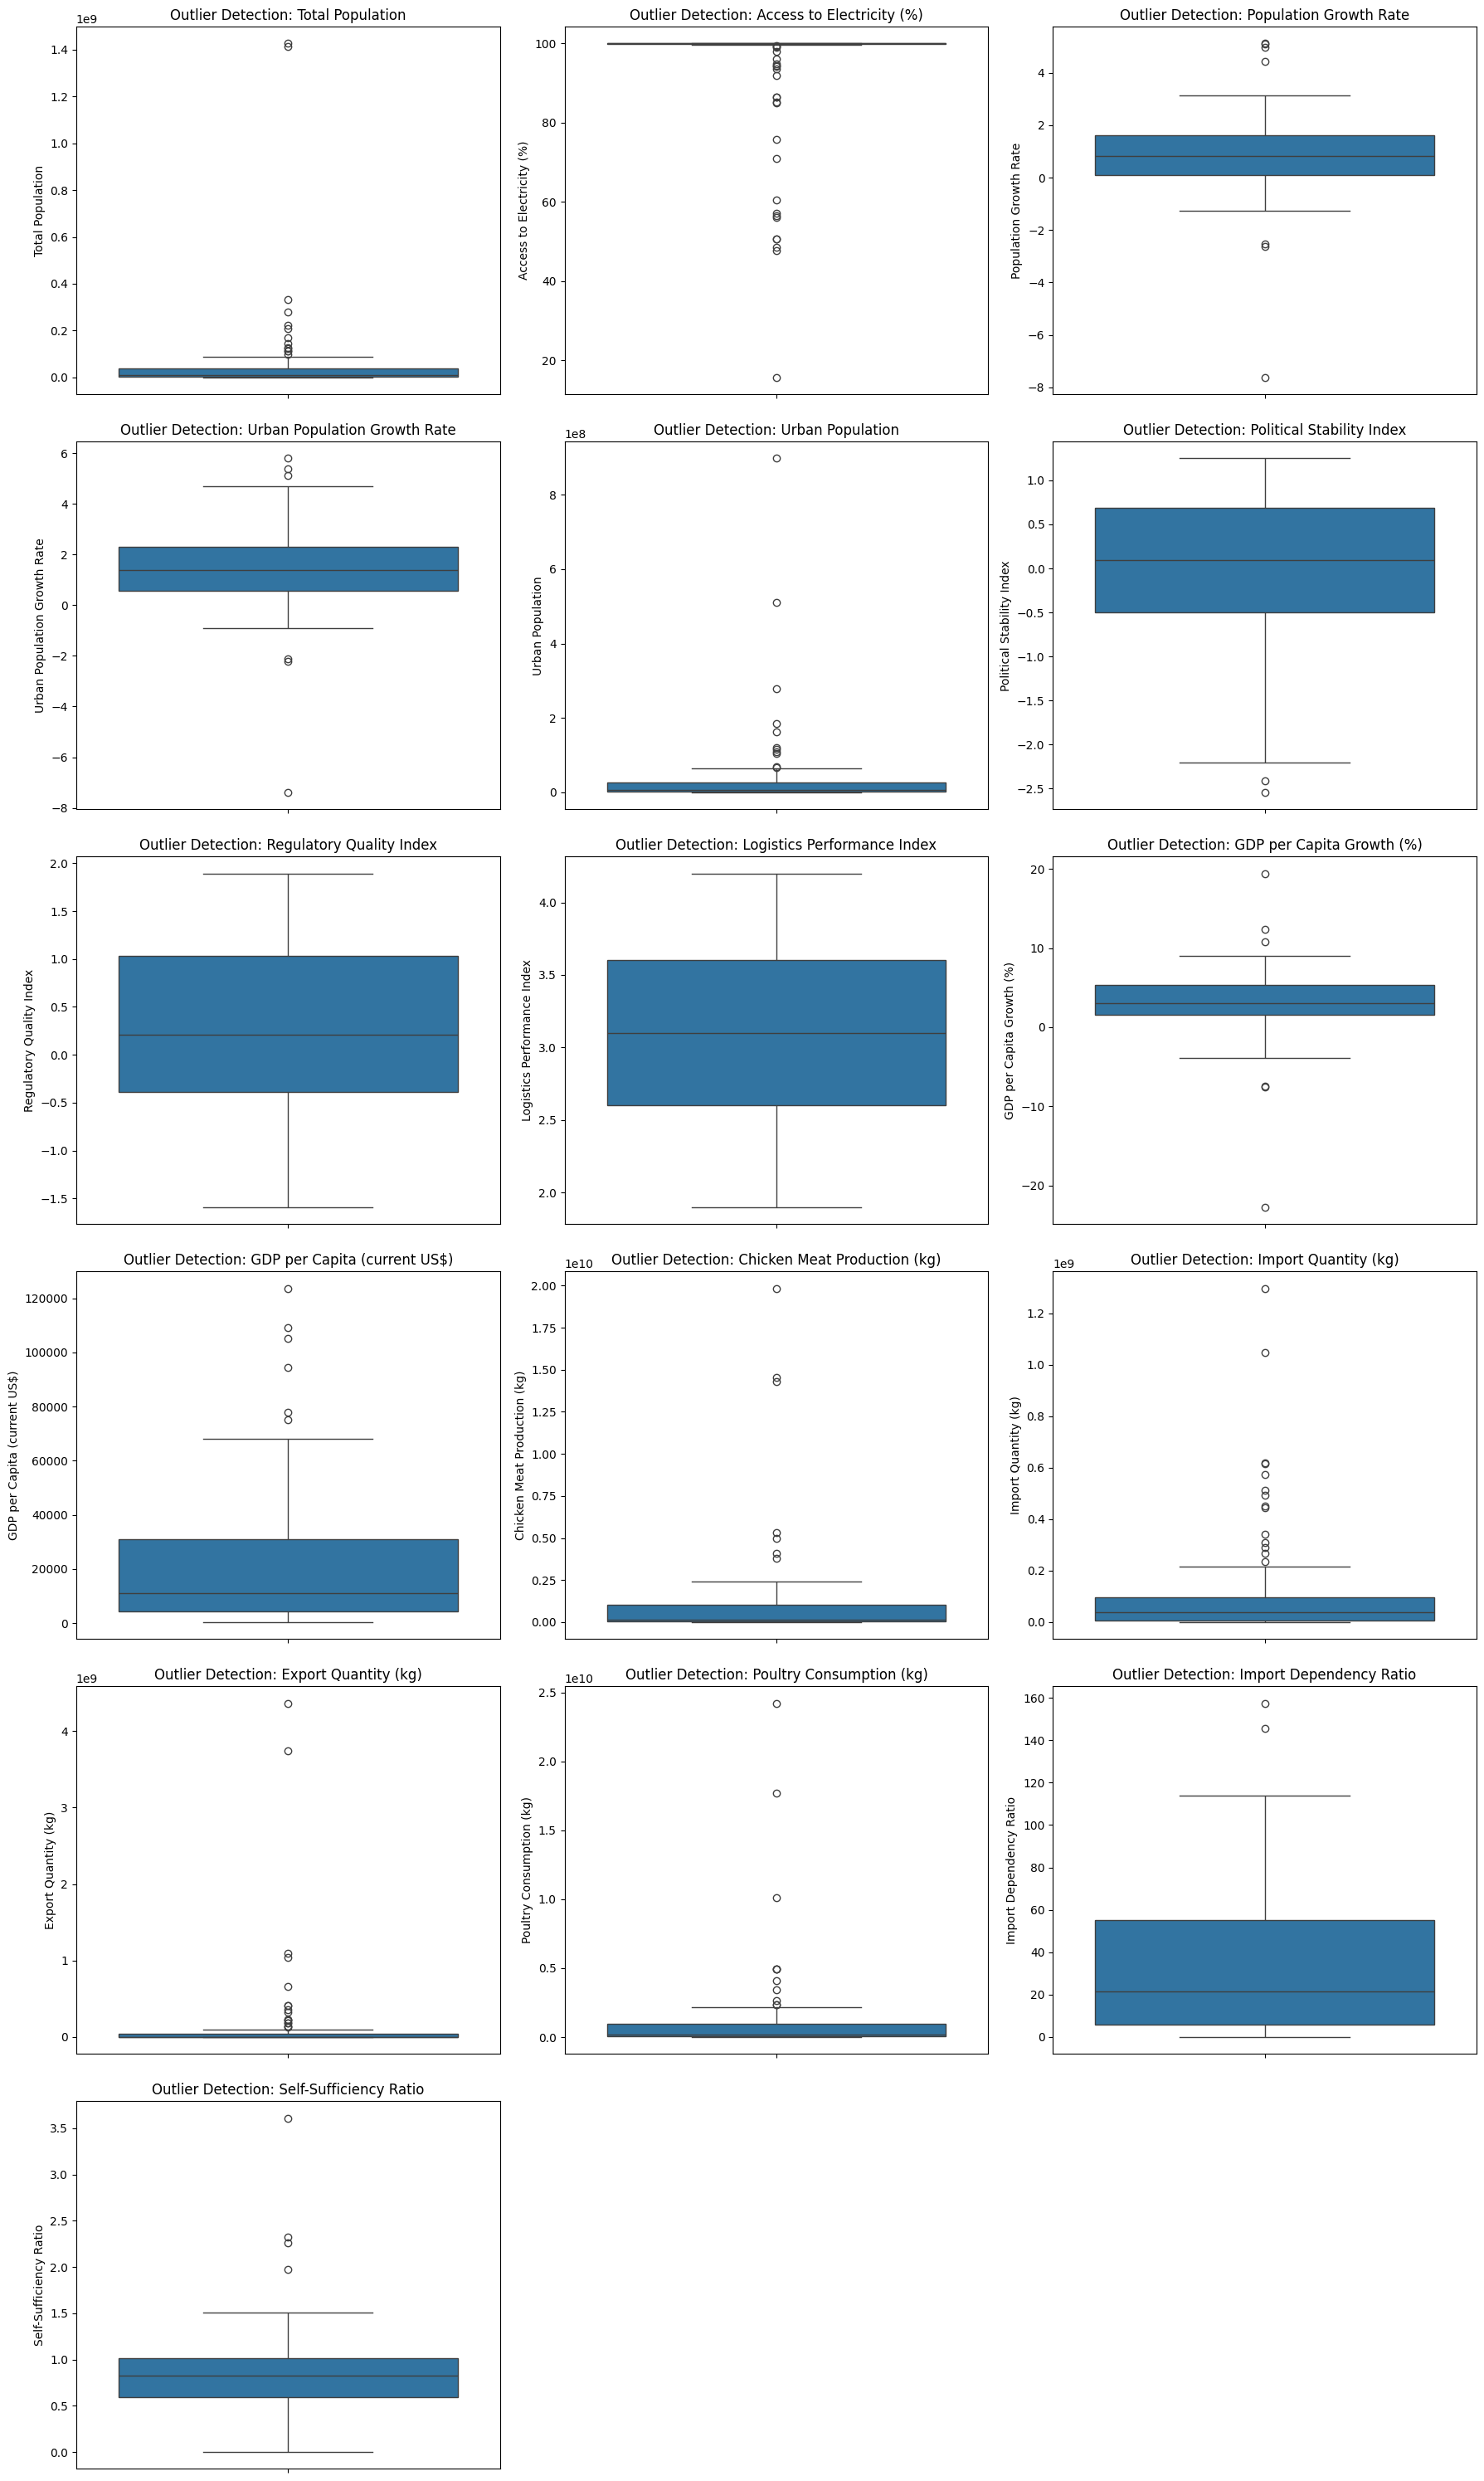

In [29]:
# Get all numerical columns
numerical_cols = df_all.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Calculate grid dimensions
n_cols = len(numerical_cols)
n_rows = (n_cols + 2) // 3  # 3 plots per row
n_plot_cols = min(3, n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_plot_cols, figsize=(18, 5*n_rows))
axes = axes.flatten() if n_cols > 1 else [axes]

# Plot each numerical column
for idx, col in enumerate(numerical_cols):
    sns.boxplot(y=df_all[col], ax=axes[idx])
    axes[idx].set_title(f'Outlier Detection: {col}')
    axes[idx].set_ylabel(col)

# Hide extra subplots if any
for idx in range(len(numerical_cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

### Top and Bottom Analysis

In [30]:
def plot_top_bottom(df, column, title_prefix, n=10, palette='viridis'):
    """Plot top and bottom n countries for a given metric"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Top n
    top = df.nlargest(n, column)[['Country Code', column]].set_index('Country Code')
    sns.barplot(x=top.index, y=top[column], palette='Blues_r', ax=axes[0])
    axes[0].set_title(f'Top {n} {title_prefix}')
    axes[0].set_xlabel('Country Code')
    axes[0].set_ylabel(column)
    axes[0].tick_params(axis='x', rotation=0)
    
    # Bottom n
    bottom = df.nsmallest(n, column)[['Country Code', column]].set_index('Country Code')
    sns.barplot(x=bottom.index, y=bottom[column], palette='Reds_r', ax=axes[1])
    axes[1].set_title(f'Bottom {n} {title_prefix}')
    axes[1].set_xlabel('Country Code')
    axes[1].set_ylabel(column)
    axes[1].tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    return top, bottom

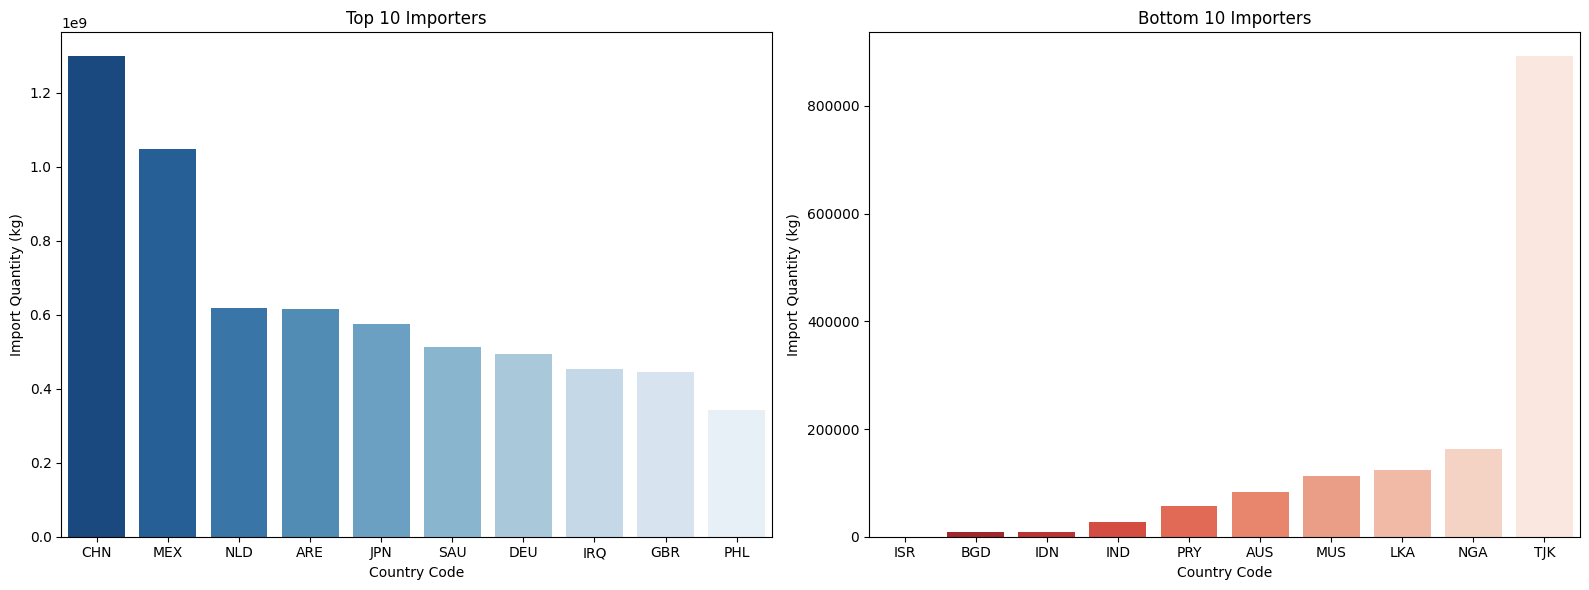


Top importer: CHN (1,298,211,070 kg)
Bottom importer: ISR (0 kg)


In [31]:
top_imp, bottom_imp = plot_top_bottom(df_all, 'Import Quantity (kg)', 'Importers', palette='Blues_r')
print(f"\nTop importer: {top_imp.index[0]} ({top_imp.iloc[0, 0]:,.0f} kg)")
print(f"Bottom importer: {bottom_imp.index[0]} ({bottom_imp.iloc[0, 0]:,.0f} kg)")

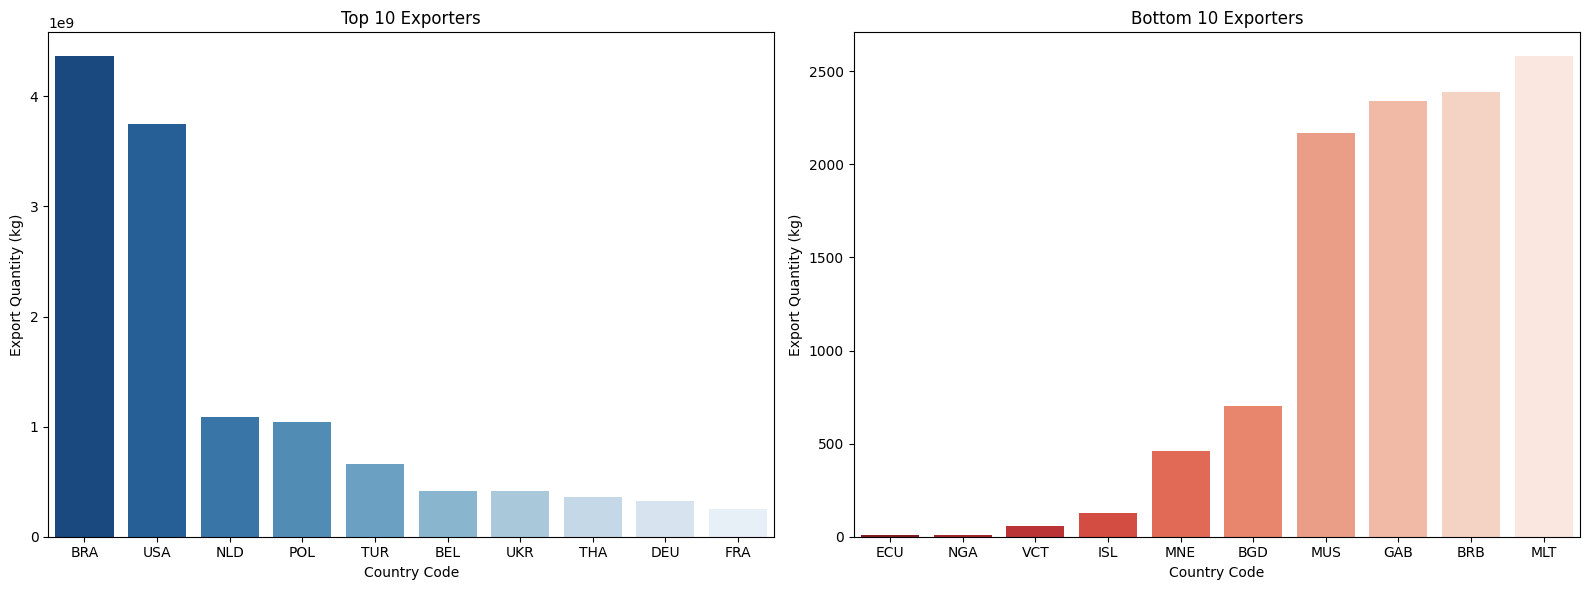


Top exporter: BRA (4,364,053,230 kg)
Bottom exporter: ECU (10 kg)


In [32]:
# Export analysis
top_exp, bottom_exp = plot_top_bottom(df, 'Export Quantity (kg)', 'Exporters', palette='Greens_r')
print(f"\nTop exporter: {top_exp.index[0]} ({top_exp.iloc[0, 0]:,.0f} kg)")
print(f"Bottom exporter: {bottom_exp.index[0]} ({bottom_exp.iloc[0, 0]:,.0f} kg)")


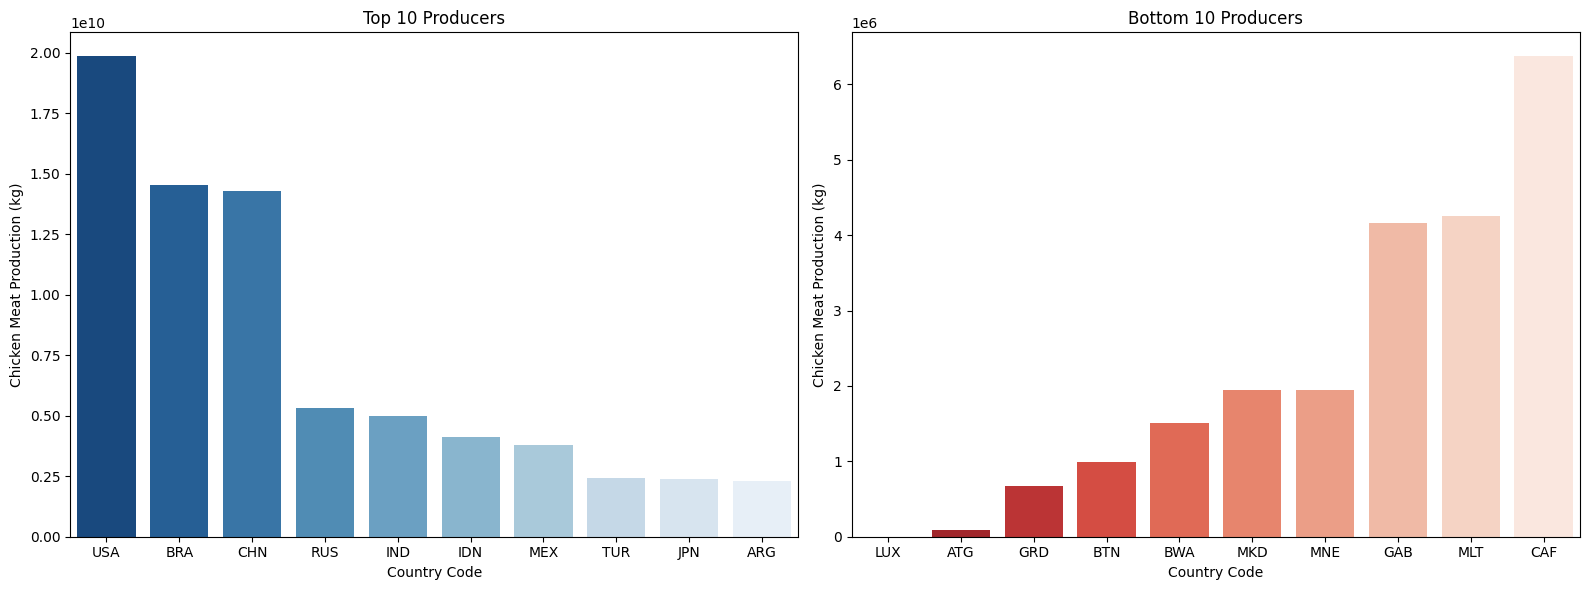


Top producer: USA (19,841,240,000 kg)
Bottom producer: LUX (0 kg)


In [33]:
## Production Analysis
top_prod, bottom_prod = plot_top_bottom(df_all, 'Chicken Meat Production (kg)', 
                                         'Producers', palette='YlOrRd')
print(f"\nTop producer: {top_prod.index[0]} ({top_prod.iloc[0, 0]:,.0f} kg)")
print(f"Bottom producer: {bottom_prod.index[0]} ({bottom_prod.iloc[0, 0]:,.0f} kg)")


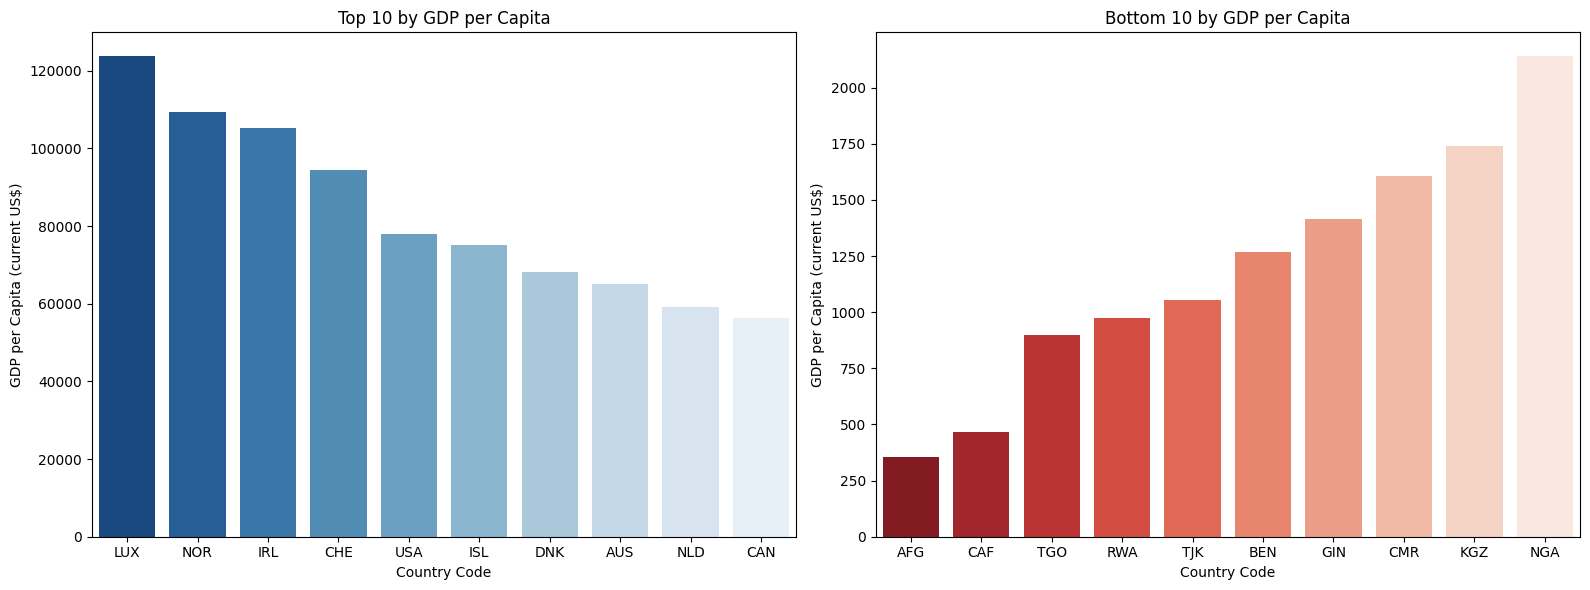


Highest GDP per capita: LUX ($123,719.66)
Lowest GDP per capita: AFG ($357.26)
Average GDP per capita: $22,253.01


In [34]:
# GDP
top_gdp, bottom_gdp = plot_top_bottom(df_all, 'GDP per Capita (current US$)', 
                                       'by GDP per Capita', palette='RdYlGn')
print(f"\nHighest GDP per capita: {top_gdp.index[0]} (${top_gdp.iloc[0, 0]:,.2f})")
print(f"Lowest GDP per capita: {bottom_gdp.index[0]} (${bottom_gdp.iloc[0, 0]:,.2f})")
print(f"Average GDP per capita: ${df_all['GDP per Capita (current US$)'].mean():,.2f}")


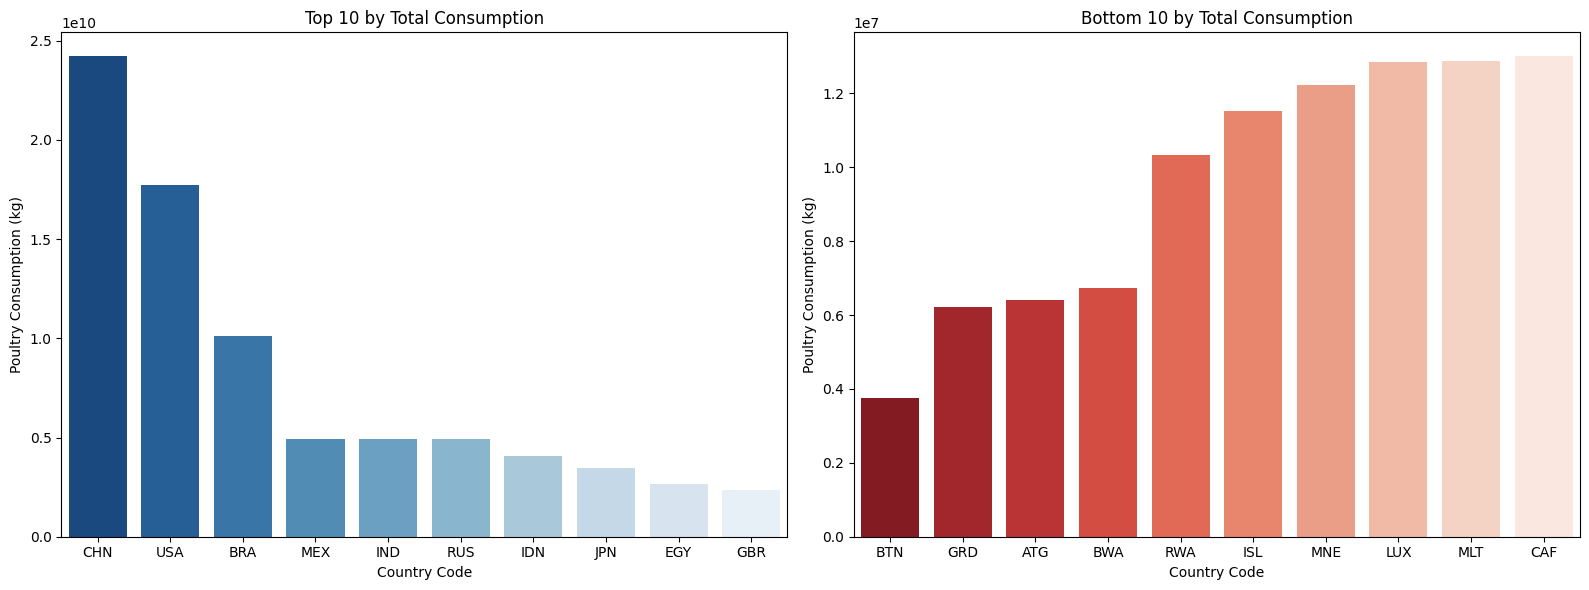


Total global consumption: 120,233,818,130 kg


In [35]:
# Total consumption
top_cons_total, _ = plot_top_bottom(df_all, 'Poultry Consumption (kg)', 
                                     'by Total Consumption', n=10, palette='plasma')
print(f"\nTotal global consumption: {df_all['Poultry Consumption (kg)'].sum():,.0f} kg")


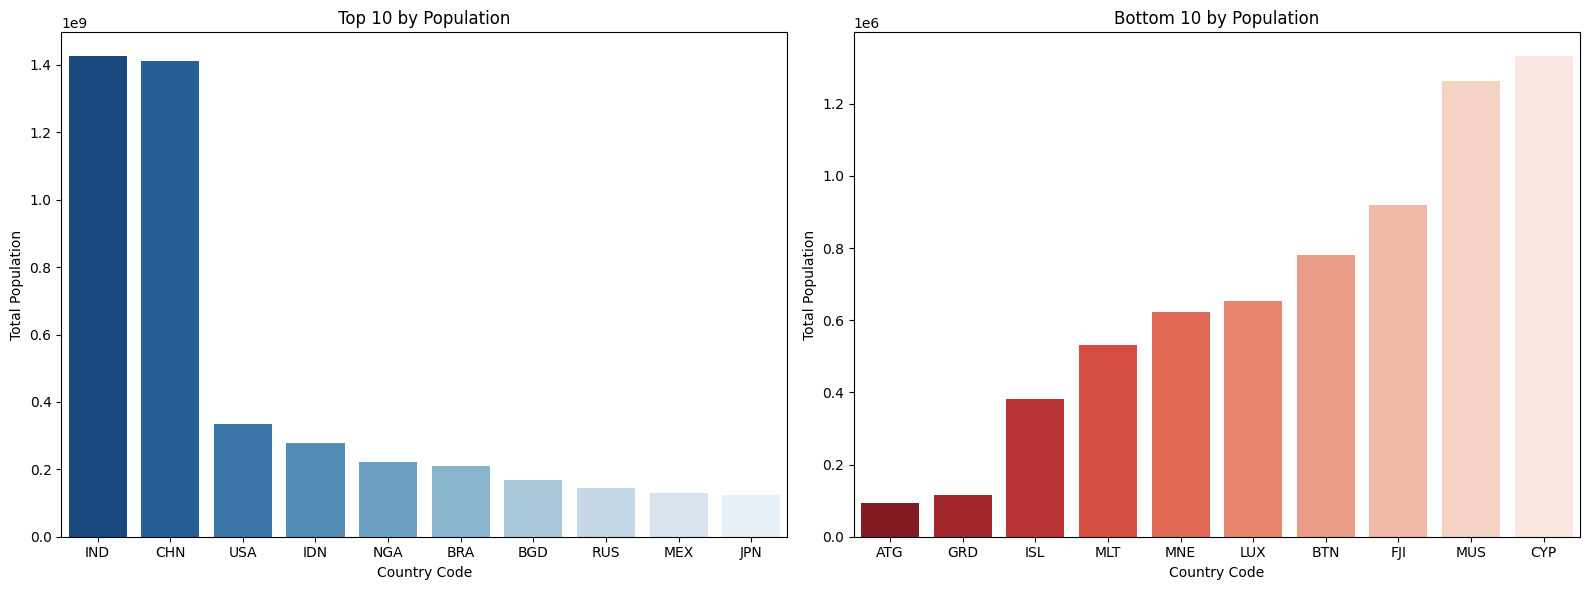


Largest population: IND (1,425,423,212)


In [36]:
# Total population
top_pop, _ = plot_top_bottom(df_all, 'Total Population', 'by Population', palette='viridis')
print(f"\nLargest population: {top_pop.index[0]} ({top_pop.iloc[0, 0]:,.0f})")

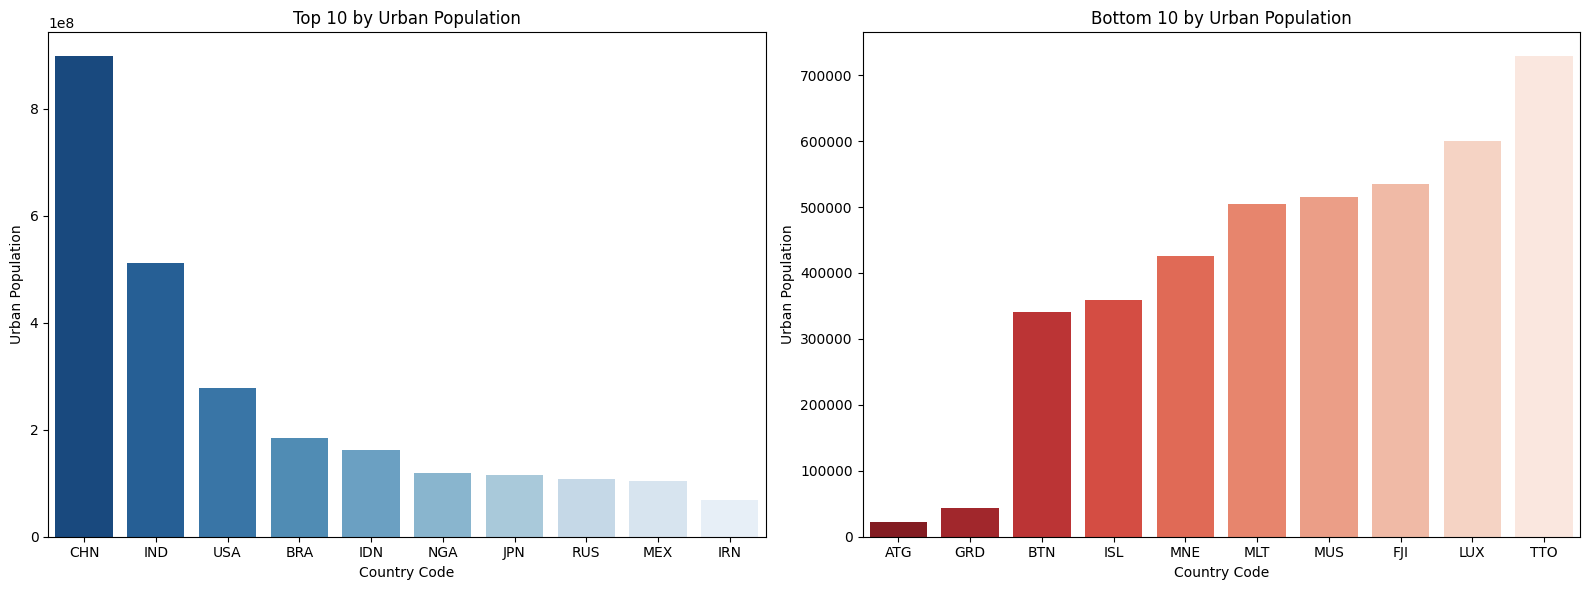


Largest urban population: CHN (897,578,430)


In [37]:
# Urban population
top_urban, _ = plot_top_bottom(df_all, 'Urban Population', 'by Urban Population', palette='cividis')
print(f"\nLargest urban population: {top_urban.index[0]} ({top_urban.iloc[0, 0]:,.0f})")

### Correlation Matrix

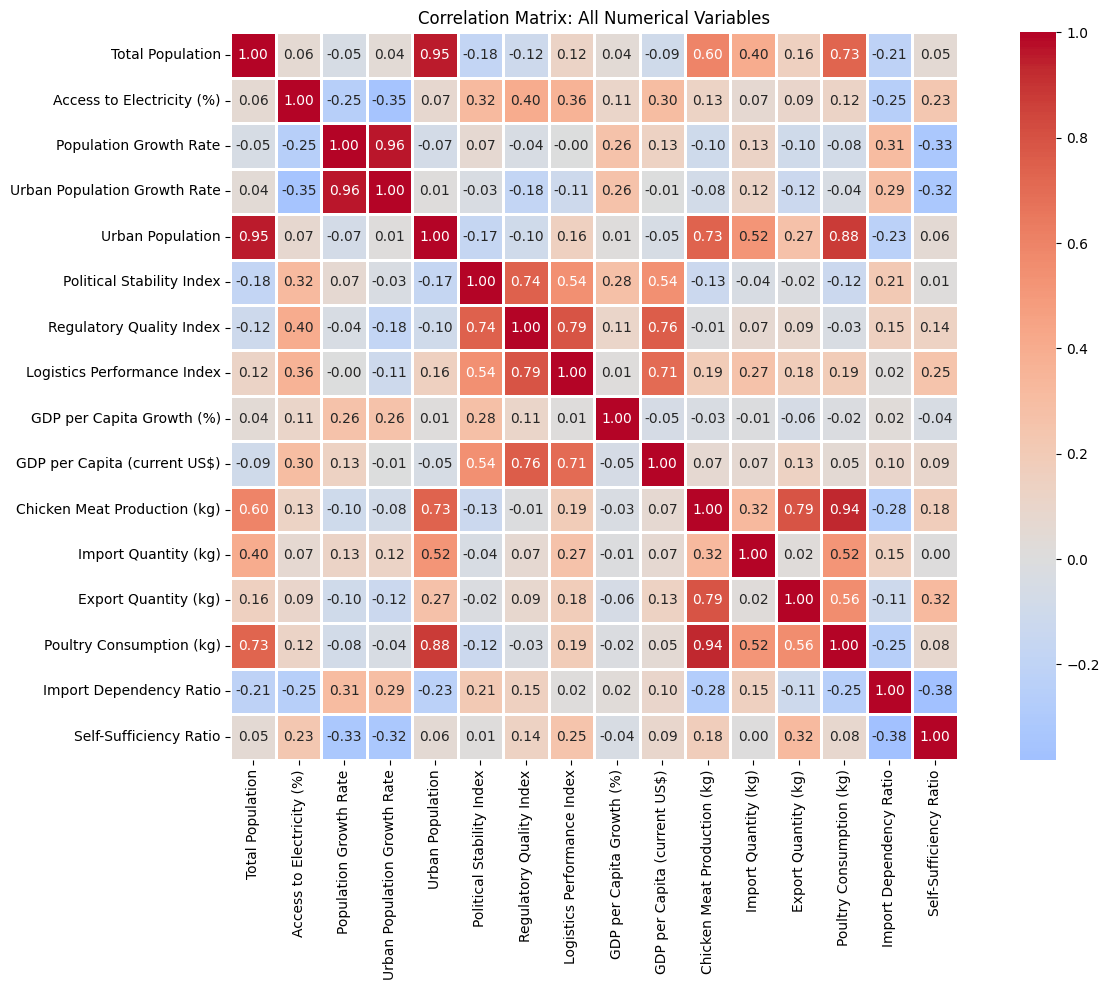


Strong correlations with Chicken Production:
Chicken Meat Production (kg)    1.000000
Poultry Consumption (kg)        0.935115
Export Quantity (kg)            0.789892
Urban Population                0.733446
Total Population                0.598584
Name: Chicken Meat Production (kg), dtype: float64


In [38]:
# Correlation heatmap
plt.figure(figsize=(14, 10))
correlation_matrix = df_all.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1)
plt.title('Correlation Matrix: All Numerical Variables')
plt.tight_layout()
plt.show()

# Identify strong correlations with production/consumption
print("\nStrong correlations with Chicken Production:")
prod_corr = correlation_matrix['Chicken Meat Production (kg)'].sort_values(ascending=False)
print(prod_corr[abs(prod_corr) > 0.5])